# Synthetic Data Experiments with PF-MCMC

In [1281]:
# Import all necesary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf

## Simulating Synthetic Data

In [908]:
def BM_SEIR(V_in, params, num_particles, N):
    # Initialize arrays to store results
    V = np.zeros([V_in.shape[0], num_particles])
    
    new_infected = np.zeros([num_particles])

    # Set initial conditions
    kappa, gamma, sigma_b, = params
    beta = np.exp(V_in[4,:])

    # Update beta(t) using Euler-Maruyama
    V[4,:] = V_in[4,:] + sigma_b * stats.norm(0, 1).rvs(num_particles)
    
    # Update SEUORDS model
    V[0, :] = V_in[0, :] - beta * V_in[0, :] * V_in[2, :] / N                                 # S-Susceptibles
    V[1, :] = V_in[1, :] + beta * V_in[0, :] * V_in[2, :] / N - kappa * V_in[1, :]            # E-Exposed
    V[2, :] = V_in[2, :] + kappa * V_in[1, :] - gamma * V_in[2, :]                            # I-Infected
    V[3, :] = V_in[3, :] + gamma * V_in[2, :]                                                 # R-Recovered
    
    new_infected =  kappa*V_in[1, :]
    
    return V, new_infected

In [909]:
T = 50
num_particles = 1

N = 100000000
E0 = stats.uniform(100,10000).rvs(num_particles)
I0 = stats.uniform(10,100).rvs(num_particles)

V_in = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(2*np.ones(num_particles))
    ])

kappa = 0.2
gamma = 0.1
sigma_b = 0.5

params = [kappa, gamma, sigma_b]

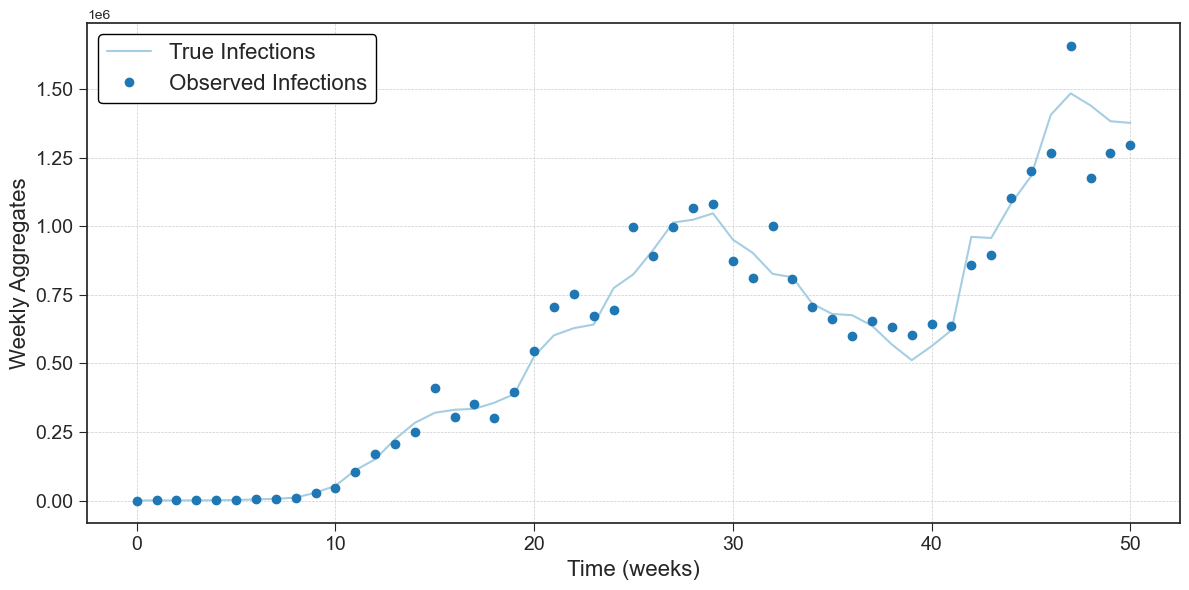

In [963]:
# Initialize the arrays to store results
states = np.zeros([V_in.shape[0], num_particles, T+1])  
states[:, :, 0] = V_in 

aggregates = np.zeros([num_particles, T+1])
aggregates[:,0] = I0  

# Run the model over T periods with weekly aggregation
for t in range(1, T+1):
    states[:, :, t], aggregates[:, t] = BM_SEIR(states[:, :, t-1], params, num_particles, N)
    
# Define log-normal likelihood to add noise to obsrvations
Y_obs = stats.nbinom(n=1/0.01, p=1/(1+0.01*aggregates)).rvs()

# Plot the simulation for each particle
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(aggregates[0,:], color=colors[0], label='True Infections')
plt.plot(Y_obs, color=colors[1], label='Observed Infections', marker='o', linewidth=0)
plt.legend(
    loc='upper left',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Aggregates', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

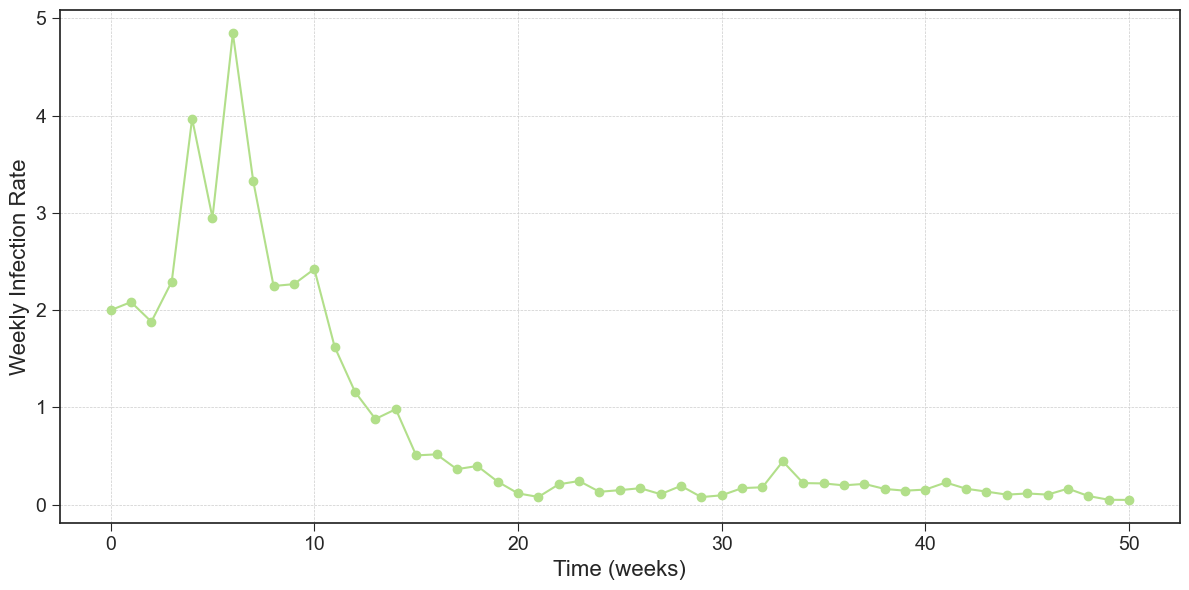

In [705]:
time = np.linspace(1, T+1, T+1)
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')
    
plt.plot(np.exp(states[4,0,:]), 
         marker='o',
         color=colors[2], 
         label='Weekly Infection Rate')

plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Infection Rate', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Bootstrap Particle Filter Approximations

Following the steps of Dahlin, J. and Schön, T. B.$^1$ we work with the shifted log weights to avoid problems with numerical precision where we define
$$
v^{(i)}_t = \log(w^{(i)}_t) - v_{max}
$$
with $v_{max} = \max_{i} \log(w^{(i)}_t)$ and $w^{(i)}_t = e^{v_{max}} e^{v^{(i)}_t}$. 

With this in mind, the normalized weights can be calculated using 
$$ 
\bar{w}^{(i)}_t = \frac{w^{(i)}_t}{\sum_i w^{(i)}_t} = \frac{e^{v_{max}} e^{v^{(i)}_t}}{\sum_i e^{v_{max}} e^{v^{(i)}_t}} = \frac{e^{v^{(i)}_t}}{\sum_i e^{v^{(i)}_t}} = \tilde{v}^{(i)}_t.
$$

Additionally, instead of calculating the marginal likelihood
$$
\hat{p}(y_{1:t}) = \hat{p}(y_{1:t-1}) \hat{p}(y_t | y_{1:t-1}) = \hat{p}(y_{1:t-1}) \left( \frac{1}{N} \sum_i w^{(i)}_t \right)
$$
we can approximate the marginal log-likelihood using $w^{(i)}_t = e^{v_{max}} e^{v^{(i)}_t}$ with
\begin{align*}
\log (\hat{p}(y_{1:t})) & = \log(\hat{p}(y_{1:t-1})) + \log\left( \sum_i w^{(i)}_t \right) - \log(N) \\
                        & = \log(\hat{p}(y_{1:t-1})) + \log\left( \sum_i e^{v_{max}} e^{v^{(i)}_t}\right) - \log(N) \\
                        & = \log(\hat{p}(y_{1:t-1})) + \log(v_{max}) + \log\left( \sum_i e^{v^{(i)}_t} \right) - \log(N)
\end{align*}

$1$: Dahlin, J., & Schön, T. B. (2019). *Getting started with particle Metropolis-Hastings for inference in nonlinear dynamical models*. Journal of Statistical Software, 88, 1–41.


In [1270]:
#Bootstrap Particle Filter
num_particles = 5000
# initial_conditions = np.repeat(V_in,num_particles).reshape(5,num_particles) #Sationary Initial Conditions
E0 = stats.uniform(100,10000).rvs(num_particles)
I0 = stats.uniform(10,100).rvs(num_particles)
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(2*np.ones(num_particles))
    ])

# Initialize PF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])

estimates = np.zeros([2,T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])

ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0
likelihood = 1

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]

weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ESS[0] = num_particles

ancestry_matrix[:,0] = np.arange(num_particles)
estimates[0,0] = np.sum(norm_weights[:,0]*weekly_infections[:,0])
estimates[1,0] = np.sum(norm_weights[:,0]*particles[-1,:,0])

for t in range(1,T+1):
    # Resample particles using Systematic Resampling
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t-1]), positions)
    ancestry_matrix[:,1:t-1] = ancestry_matrix[resample_indices,1:t-1]
    ancestry_matrix[:,t] = resample_indices
    
    # Propagate particles to next week
    particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:, resample_indices, t-1], params, num_particles, N)

    # Update particle weights
    incremental_weights = stats.lognorm(weekly_infections[:,t], 0.1).logpdf(Y_obs[t])
    #stats.nbinom(n=1/0.1, p=1/(1+0.1*weekly_infections[:,t])).logpmf(Y_obs[t])

    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights    
    
    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
    estimates[0,t] = np.sum(norm_weights[:,t]*weekly_infections[:,t])
    estimates[1,t] = np.sum(norm_weights[:,t]*particles[-1,:,t])

    if np.isnan(loglikelihood):
        print(t)
        break
    
print(loglikelihood)

-837.2376884282556


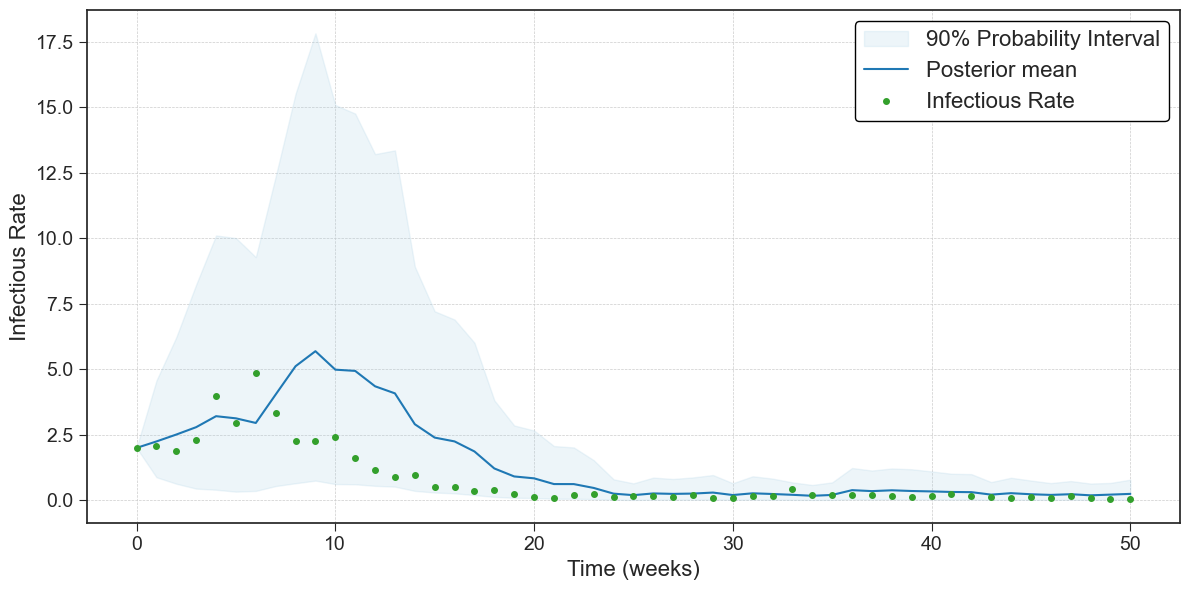

In [735]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

beta_lineage = np.exp(particles[-1,ancestry_matrix[:, -1].astype(int),:])
posterior_mean = np.mean(beta_lineage, axis=0)

# Compute 90% probability intervals
lower_bound = np.percentile(beta_lineage, 5, axis=0)
upper_bound = np.percentile(beta_lineage, 95, axis=0)

plt.fill_between(time, lower_bound, upper_bound, color=colors[0], alpha=0.2, label='90% Probability Interval')
plt.plot(posterior_mean, color=colors[1], label='Posterior mean')
plt.plot(np.exp(states[4,0,:]), marker='o', markersize=4, linewidth=0, color=colors[3], label='Infectious Rate')

plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Infectious Rate', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

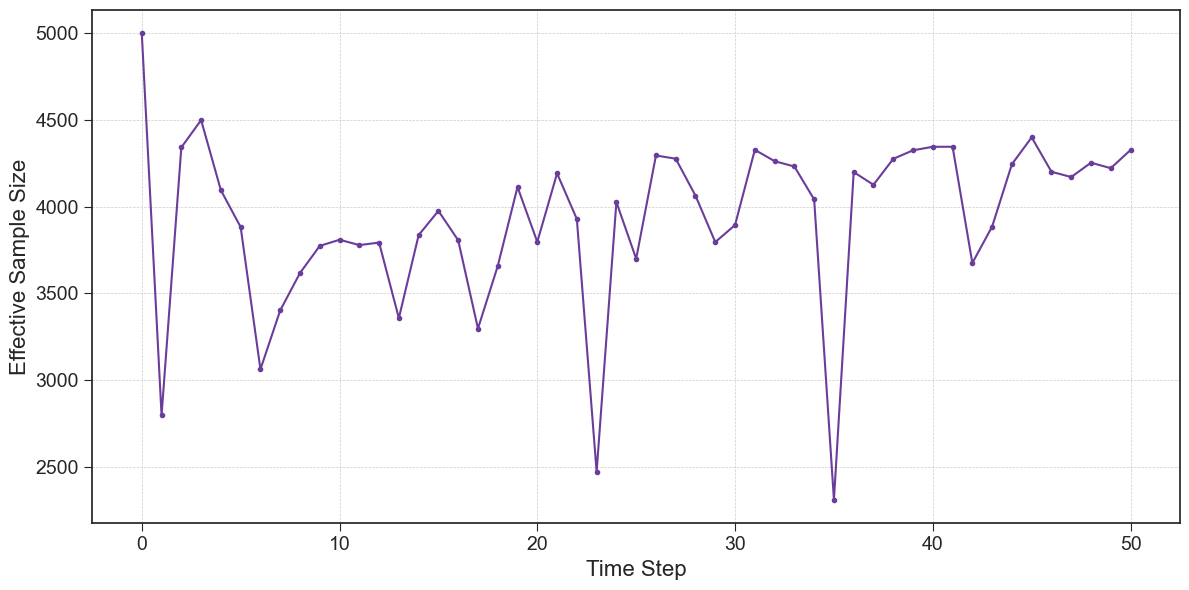

In [737]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(ESS, marker='o', markersize=3, color=colors[-3])

plt.xlabel('Time Step', fontsize=16)
plt.ylabel('Effective Sample Size', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Auxiliary Particle Filter Approximations

In [1278]:
num_particles = 5000
# initial_conditions = np.repeat(V_in,num_particles).reshape(5,num_particles) #Sationary Initial Conditions
E0 = stats.uniform(100,10000).rvs(num_particles)
I0 = stats.uniform(10,100).rvs(num_particles)
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,10).rvs(num_particles))
    ])

# Initialize PF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])

estimates = np.zeros([2,T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])

aux_weights = np.zeros([num_particles, T+1])
norm_aux_weights = np.zeros([num_particles, T+1])

ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]

weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ESS[0] = num_particles

ancestry_matrix[:,0] = np.arange(num_particles)
estimates[0,0] = np.sum(norm_weights[:,0]*weekly_infections[:,0])
estimates[1,0] = np.sum(norm_weights[:,0]*particles[-1,:,0])

for t in range(1,T+1):
    # Resample Particles
    forward_particles, forward_infections = BM_SEIR(particles[:, :, t-1], params, num_particles, N)

    incremental_aux_weights = stats.nbinom(n=1/0.1, p=1/(1+0.1*np.mean(forward_infections))).logpmf(Y_obs[t])
    incremental_aux_weights += np.log(norm_weights[:,t-1])
    
    max_aux_weights = np.max(incremental_aux_weights)
    aux_weights[:,t] = np.exp(incremental_aux_weights - max_aux_weights)
    sum_aux_weights = aux_weights[:,t].sum()
    norm_aux_weights[:,t] = aux_weights[:,t] / sum_aux_weights
    
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_aux_weights[:,t]), positions)
    ancestry_matrix[:,1:t-1] = ancestry_matrix[resample_indices,1:t-1]
    ancestry_matrix[:,t] = resample_indices

    
    # Propagate particles to next week
    particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:, resample_indices, t-1], params, num_particles, N)

    # Update particle weights
    incremental_weights = stats.nbinom(n=1/0.1, p=1/(1+0.1*weekly_infections[:,t])).logpmf(Y_obs[t])
    incremental_weights += np.log(norm_weights[resample_indices,t-1]) - np.log(norm_aux_weights[resample_indices,t])
    
    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights
    
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
    if np.isnan(loglikelihood):
        break

    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    estimates[0,t] = np.sum(norm_weights[:,t]*weekly_infections[:,t])
    estimates[1,t] = np.sum(norm_weights[:,t]*particles[-1,:,t])

print(loglikelihood)

-633.3243272226216


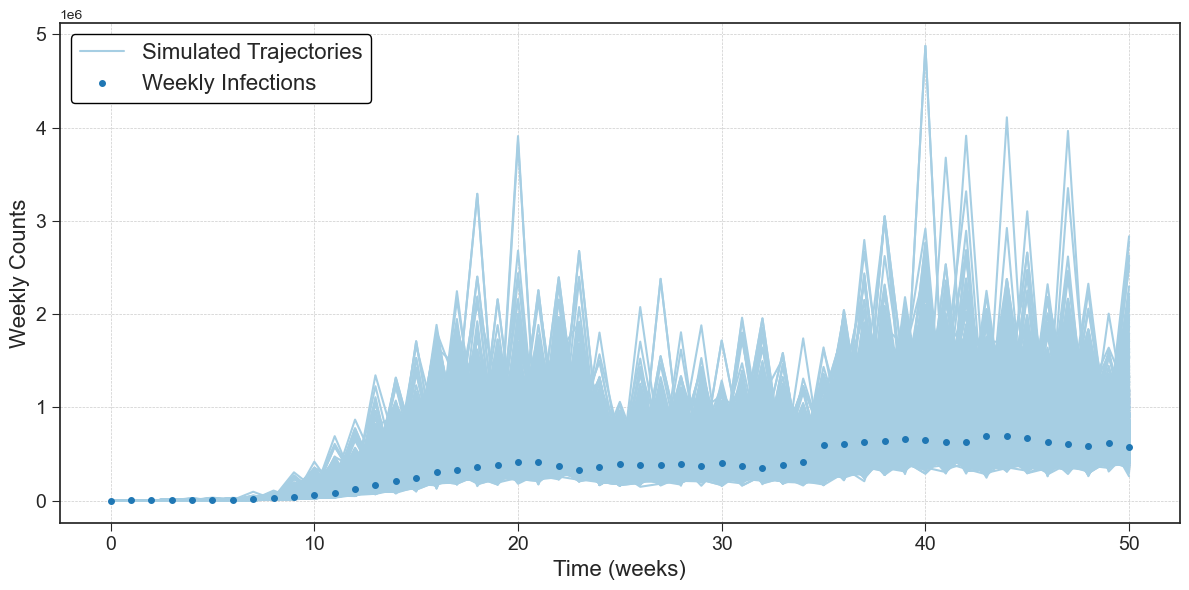

In [744]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(1, num_particles):
    infected_trajectories = weekly_infections[ancestry_matrix[p, -1].astype(int),:]
    plt.plot(infected_trajectories[:], color=colors[0])
infected_trajectories = weekly_infections[ancestry_matrix[0, -1].astype(int),:]
plt.plot(infected_trajectories[:], color=colors[0], label='Simulated Trajectories')
plt.plot(aggregates[0,:], marker='o', markersize=4, linewidth=0, label='Weekly Infections')

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Counts', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

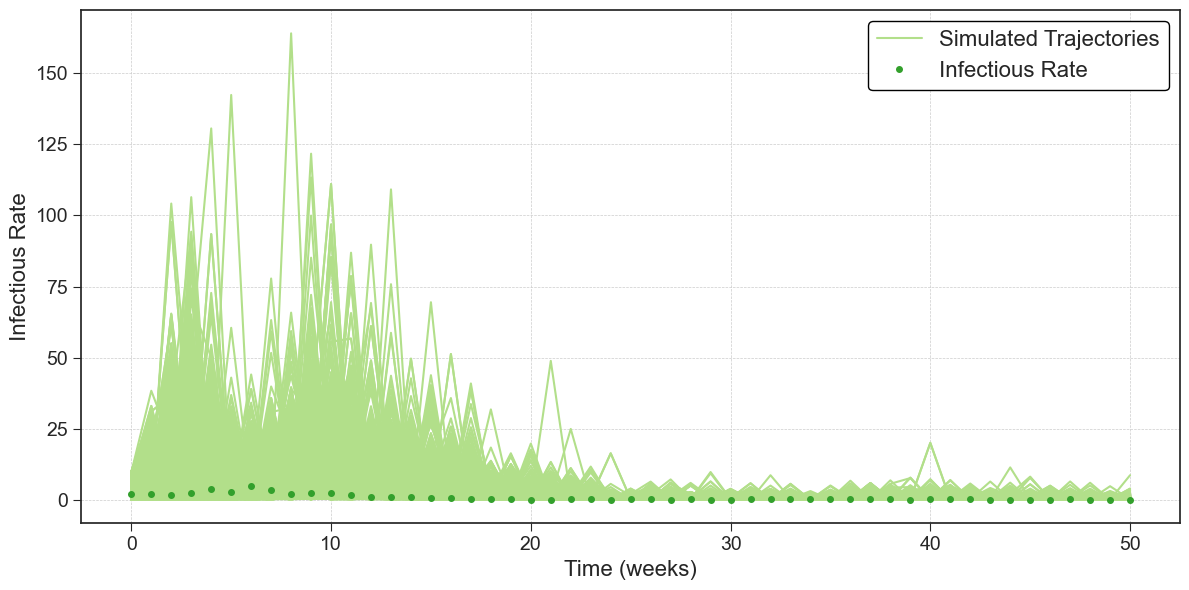

In [745]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(1,num_particles):
    state_trajectories = particles[:,ancestry_matrix[p, -1].astype(int),np.arange(T+1)]
    plt.plot(np.exp(state_trajectories[-1,:]), color=colors[2])

state_trajectories = particles[:,ancestry_matrix[0, -1].astype(int),np.arange(T+1)]
plt.plot(np.exp(state_trajectories[-1,:]), color=colors[2], label='Simulated Trajectories')
    
plt.plot(np.exp(states[4,0,:]), marker='o', markersize=4, linewidth=0, color=colors[3], label='Infectious Rate')

plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Infectious Rate', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

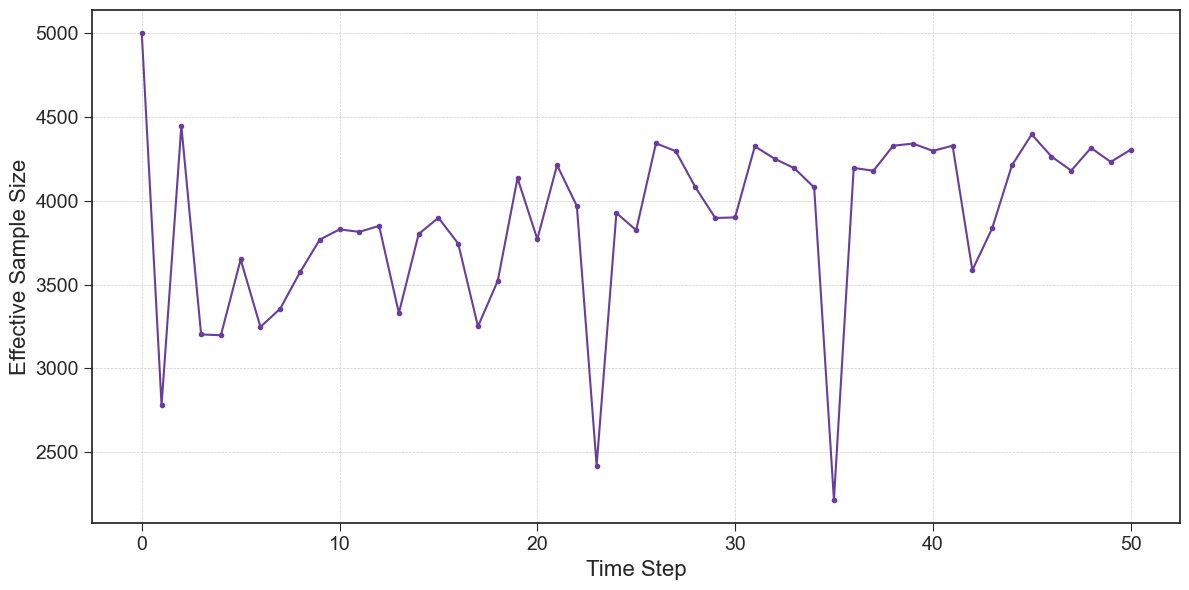

In [746]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(ESS, marker='o', markersize=3, color=colors[-3])

plt.xlabel('Time Step', fontsize=16)
plt.ylabel('Effective Sample Size', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## PF-MCMC for BM-SEIR model

In [857]:
def BPF(Y_obs, N, T, num_particles, params, initial_conditions, BM_SEIR):
    
    # Initialize BPF variables
    particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
    weekly_infections = np.zeros([num_particles, T+1])

    weights = np.zeros([num_particles, T+1])
    norm_weights = np.zeros([num_particles, T+1])

    ancestry_matrix = np.zeros([num_particles, T+1])
    ESS = np.zeros(T+1)
    loglikelihood = 0

    # Define values at time t=0
    particles[:, :, 0] = initial_conditions
    weekly_infections[:,0] = particles[2, :, 0]

    weights[:,0] = 1 / num_particles
    norm_weights[:,0] = weights[:,0]
    ESS[0] = num_particles

    ancestry_matrix[:,0] = np.arange(num_particles)

    for t in range(1,T+1):
        # Resample particles using Systematic Resampling
        r = stats.uniform(0,1).rvs()
        positions =  (np.arange(num_particles) + r )/num_particles
        resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t-1]), positions)
        ancestry_matrix[:,1:t-1] = ancestry_matrix[resample_indices,1:t-1]
        ancestry_matrix[:,t] = resample_indices
        
        # Propagate particles to next week
        particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:, resample_indices, t-1], params, num_particles, N)

        # Update particle weights
        incremental_weights = stats.nbinom(n=1/0.1, p=1/(1+0.1*weekly_infections[:,t])).logpmf(Y_obs[t])

        max_weights = np.max(incremental_weights)
        weights[:,t] = np.exp(incremental_weights - max_weights)
        sum_weights = weights[:,t].sum()
        norm_weights[:,t] = weights[:,t] / sum_weights
        
        ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
        loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)

        if np.isnan(loglikelihood):
            break
                
    if norm_weights[:,-1].sum() != 1:
        chosen_index = np.random.choice(a=np.arange(num_particles), size=1, p=np.ones(num_particles)/num_particles)
    else:
        chosen_index = np.random.choice(a=np.arange(num_particles), size=1, p=norm_weights[:, -1])
    
    return loglikelihood, weekly_infections[ancestry_matrix[chosen_index, -1].astype(int),:], np.exp(particles[-1,ancestry_matrix[chosen_index, -1].astype(int),:])

In [755]:
BPF(Y_obs, N, T, num_particles, params, initial_conditions, BM_SEIR)

(np.float64(-620.4214270973317),
 array([[5.90392279e+01, 1.66996550e+03, 1.19300436e+03, 8.94587472e+02,
         8.60421574e+02, 2.68340419e+03, 3.67699245e+03, 8.55973007e+03,
         1.86266909e+04, 4.90661651e+04, 4.74518800e+04, 9.03274793e+04,
         7.04949252e+04, 2.08850757e+05, 2.55879164e+05, 3.06444696e+05,
         3.46524745e+05, 3.43847997e+05, 3.37083756e+05, 4.22068930e+05,
         4.32437295e+05, 5.93051303e+05, 5.09917462e+05, 9.39052696e+05,
         3.13549517e+05, 3.22053858e+05, 2.16356848e+05, 3.14186486e+05,
         2.26369391e+05, 6.24644991e+05, 7.55845399e+05, 6.30034684e+05,
         3.93177013e+05, 5.78318307e+05, 2.80670054e+05, 3.26879036e+05,
         5.85942716e+05, 5.71616080e+05, 7.13128470e+05, 5.21153048e+05,
         1.23942611e+06, 7.09745823e+05, 1.15422377e+06, 4.70078560e+05,
         9.75672460e+05, 5.71953949e+05, 7.51365927e+05, 7.14224507e+05,
         4.72059025e+05, 6.57532851e+05, 6.11117666e+05]]),
 array([[0.56797931, 0.49598868

In [968]:
num_particles = 3000
num_iterations = 150000
# initial_conditions = np.repeat(V_in,num_particles).reshape(5,num_particles) #Sationary Initial Conditions
E0 = stats.uniform(100,10000).rvs(num_particles)
I0 = stats.uniform(10,100).rvs(num_particles)
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,5).rvs(num_particles))
    ])

current_theta = np.array([
    stats.uniform().rvs(),
    stats.uniform().rvs(),
    stats.uniform().rvs()
])

stepSize = np.diag([
    0.1**2,
    0.1**2,
    0.15**2
])

print('Initial conditions: ',np.mean(initial_conditions, axis=1))
print('Initial parameters: ',current_theta)
print('Real parameters: ',params)

Initial conditions:  [9.99948584e+07 5.08151397e+03 6.00656601e+01 0.00000000e+00
 5.77474526e-01]
Initial parameters:  [0.56618929 0.95838286 0.74875031]
Real parameters:  [0.2, 0.1, 0.5]


In [969]:
theta_samples = np.zeros([current_theta.shape[0],num_iterations])
weekly_trajectories = np.zeros([T+1,num_iterations])
beta_trajectories = np.zeros([T+1,num_iterations])
loglikelihoods = np.zeros(num_iterations)

rejected_count = 0
acceptance_count = 0
AccRate = 0

current_loglik, current_weekly, current_betas  = BPF(Y_obs, N, T, num_particles, current_theta, initial_conditions, BM_SEIR)

print("Initial parameters:", current_theta)
print("Initial log-likelihood:", current_loglik)

theta_samples[:,0] = current_theta
loglikelihoods[0] = current_loglik
weekly_trajectories[:,0] = current_weekly
beta_trajectories[:,0] = current_betas

for i in range(1,num_iterations):
    proposed_theta = theta_samples[:, i-1] + stats.multivariate_normal(mean=np.zeros(current_theta.shape[0]), cov=stepSize).rvs()
    
    if (proposed_theta[0] < 0) or (proposed_theta[0] > 1) or (proposed_theta[1] < 0) or (proposed_theta[1] > 1)  or (proposed_theta[2] < 0) or (proposed_theta[2] > 1):
        rejected_count += 1
        proposed_loglik = -np.inf
        accept_prob = 0
    else:
        proposed_loglik, proposed_weekly, proposed_betas  = BPF(Y_obs, N, T, num_particles, proposed_theta, initial_conditions, BM_SEIR)
        log_lik_ratio = proposed_loglik - loglikelihoods[i-1]
        accept_prob = min(1,np.exp(log_lik_ratio))
    
    if stats.uniform(0,1).rvs() < accept_prob:
        theta_samples[:,i] = proposed_theta
        weekly_trajectories[:,i] = proposed_weekly
        beta_trajectories[:,i] = proposed_betas
        
        loglikelihoods[i] = proposed_loglik
        acceptance_count += 1
    else:
        theta_samples[:,i] = theta_samples[:,i-1]
        weekly_trajectories[:,i] = weekly_trajectories[:,i-1]
        beta_trajectories[:,i] = beta_trajectories[:,i-1]

        loglikelihoods[i] = loglikelihoods[i-1]
        
    AccRate = acceptance_count / (i + 1)
    if i % 500 == 0:
        print(f"Iteration {i}: Acceptance Rate = {AccRate:.2%}")
        print('Rejected Samples: ', rejected_count)
        print('proposed loglik', proposed_loglik)
        print('Accept prob: ', accept_prob)

Initial parameters: [0.56618929 0.95838286 0.74875031]
Initial log-likelihood: -649.3727254506476


/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_52622/430481112.py:30: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(log_lik_ratio))


Iteration 500: Acceptance Rate = 40.52%
Rejected Samples:  148
proposed loglik -634.4571036728516
Accept prob:  0.11657468787156573
Iteration 1000: Acceptance Rate = 38.06%
Rejected Samples:  317
proposed loglik -631.7342545886554
Accept prob:  1
Iteration 1500: Acceptance Rate = 38.51%
Rejected Samples:  461
proposed loglik -641.8858812199834
Accept prob:  0.01586799857344317
Iteration 2000: Acceptance Rate = 38.63%
Rejected Samples:  584
proposed loglik -639.8582770396828
Accept prob:  0.00017786124142206213
Iteration 2500: Acceptance Rate = 38.46%
Rejected Samples:  682
proposed loglik -635.8137804779077
Accept prob:  1
Iteration 3000: Acceptance Rate = 39.22%
Rejected Samples:  813
proposed loglik nan
Accept prob:  1
Iteration 3500: Acceptance Rate = 39.45%
Rejected Samples:  921
proposed loglik -inf
Accept prob:  0
Iteration 4000: Acceptance Rate = 39.79%
Rejected Samples:  1036
proposed loglik -732.7217950636086
Accept prob:  4.872082521886063e-44
Iteration 4500: Acceptance Rate 

In [1269]:
import os
import pickle

# Define the folder path
data_folder = '/Users/ro/Desktop/Undergrad_AM_Thesis/Notebooks'

# Define the full path for the file
file_path = os.path.join(data_folder, 'synthetic_final_results.pkl')

# Save the pickle file
results = {
    'theta_samples': theta_samples,
    'weekly_trajectories': weekly_trajectories,
    'vector_trajectories': beta_trajectories,
    'loglikelihoods': loglikelihoods,
    'acceptance_count': acceptance_count,
    'rejected_count': rejected_count,
    'AccRate': AccRate
}

with open(file_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Final results saved to {file_path}")

Final results saved to /Users/ro/Desktop/Undergrad_AM_Thesis/Notebooks/synthetic_final_results.pkl


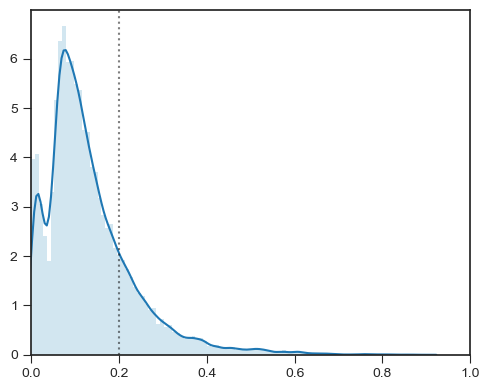

In [1417]:
plt.figure(figsize=(5, 4))
plt.hist(
    theta_samples[0, 50000:], 
    bins=100, 
    color=colors[0], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(theta_samples[0,50000:], linewidth=1.5, color=colors[1])
plt.axvline(params[0], color='black', linestyle=":", alpha=0.5)
plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()

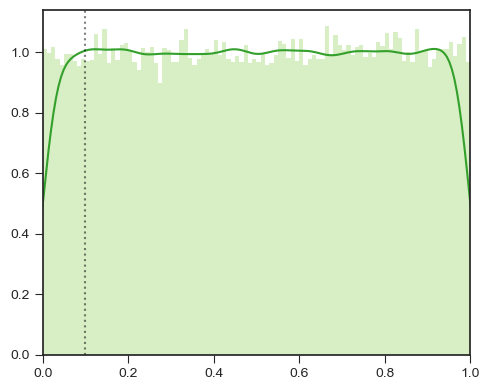

In [1280]:
plt.figure(figsize=(5, 4))
plt.hist(
    stats.uniform(0,1).rvs(100000), 
    bins=100, 
    color=colors[2], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(stats.uniform(0,1).rvs(100000), linewidth=1.5, color=colors[3])
plt.axvline(params[1], color='black', linestyle=":", alpha=0.5)

plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()

In [1385]:
np.median(theta_samples[1,50000:])

np.float64(0.38498065960999434)

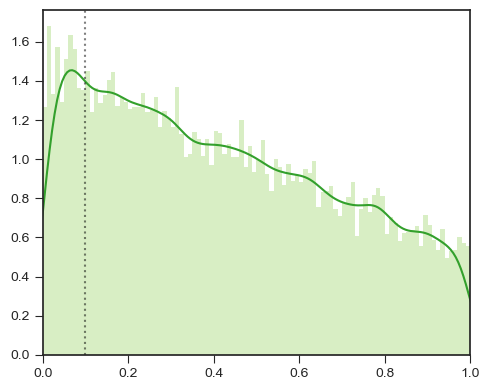

In [1224]:
plt.figure(figsize=(5, 4))
plt.hist(
    theta_samples[1, 50000:], 
    bins=100, 
    color=colors[2], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(theta_samples[1,50000:], linewidth=1.5, color=colors[3])
plt.axvline(params[1], color='black', linestyle=":", alpha=0.5)

plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()

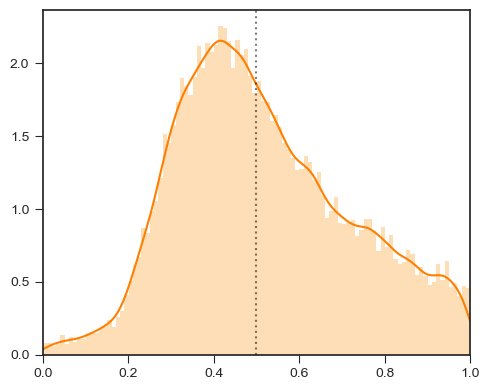

In [1225]:
plt.figure(figsize=(5, 4))
plt.hist(
    theta_samples[2, 50000:], 
    bins=100, 
    color=colors[6], 
    density=True,  
    edgecolor='none',
    alpha=0.5
)
sns.kdeplot(theta_samples[2,50000:], linewidth=1.5, color=colors[7])
plt.axvline(params[2], color='black', linestyle=":", alpha=0.5)

plt.xlim(0,1)
plt.ylabel('')
plt.tight_layout()
plt.show()

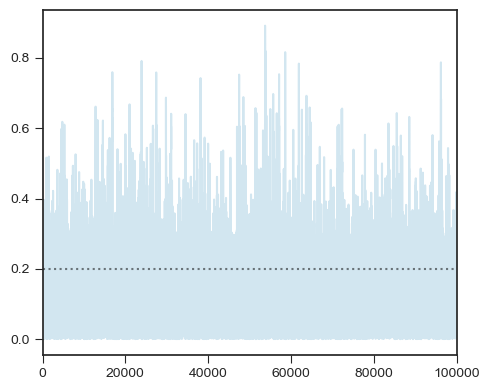

In [1241]:
plt.figure(figsize=(5, 4))

plt.plot(theta_samples[0,50000:], color=colors[0], alpha=0.5)
plt.axhline(params[0], color='black', linestyle=':', alpha=0.5)

plt.xlim(0,100000)
plt.tight_layout()
plt.show()

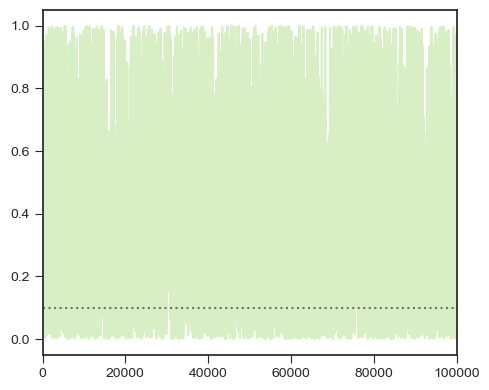

In [1239]:
plt.figure(figsize=(5, 4))

plt.plot(theta_samples[1,50000:], color=colors[2], alpha=0.5)
plt.axhline(params[1], color='black', linestyle=':', alpha=0.5)

plt.xlim(0,100000)
plt.tight_layout()
plt.show()

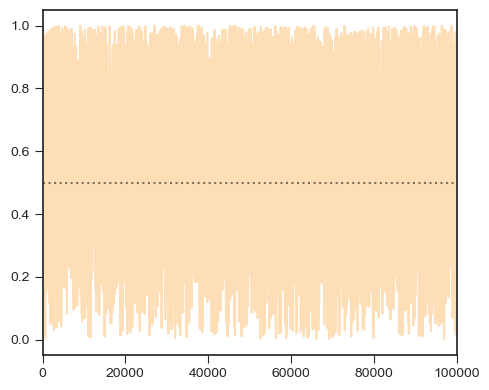

In [1243]:
plt.figure(figsize=(5, 4))

plt.plot(theta_samples[2,50000:], color=colors[6], alpha=0.5)
plt.axhline(params[2], color='black', linestyle=':', alpha=0.5)

plt.xlim(0,100000)
plt.tight_layout()
plt.show()

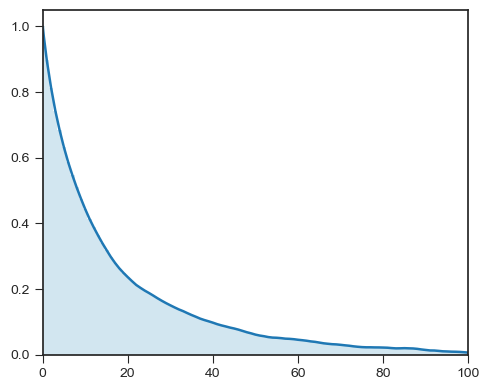

In [1247]:
autocorr = acf(theta_samples[0,50000:], nlags=100, fft=True)

plt.figure(figsize=(5, 4))
plt.plot(autocorr, color=colors[1], linewidth=1.8)
plt.bar(range(100 + 1), autocorr, color=colors[0], width=1, alpha=0.5)

plt.xlim(0,100)
plt.tight_layout()
plt.show()

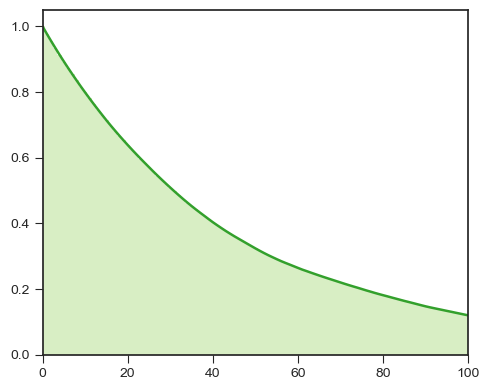

In [1248]:
autocorr = acf(theta_samples[1,50000:], nlags=100, fft=True)

plt.figure(figsize=(5, 4))
plt.plot(autocorr, color=colors[3], linewidth=1.8)
plt.bar(range(100 + 1), autocorr, color=colors[2], width=1, alpha=0.5)

plt.xlim(0,100)
plt.tight_layout()
plt.show()

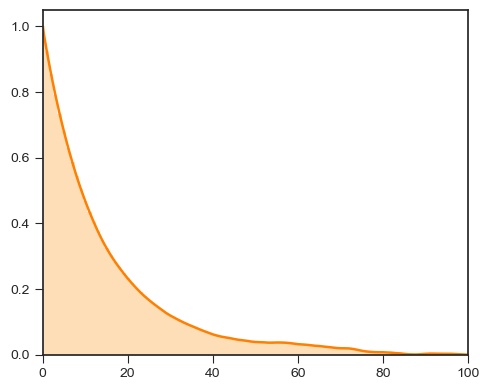

In [1249]:
autocorr = acf(theta_samples[2,50000:], nlags=100, fft=True)

plt.figure(figsize=(5, 4))
plt.plot(autocorr, color=colors[7], linewidth=1.8)
plt.bar(range(100 + 1), autocorr, color=colors[6], width=1, alpha=0.5)

plt.xlim(0,100)
plt.tight_layout()
plt.show()

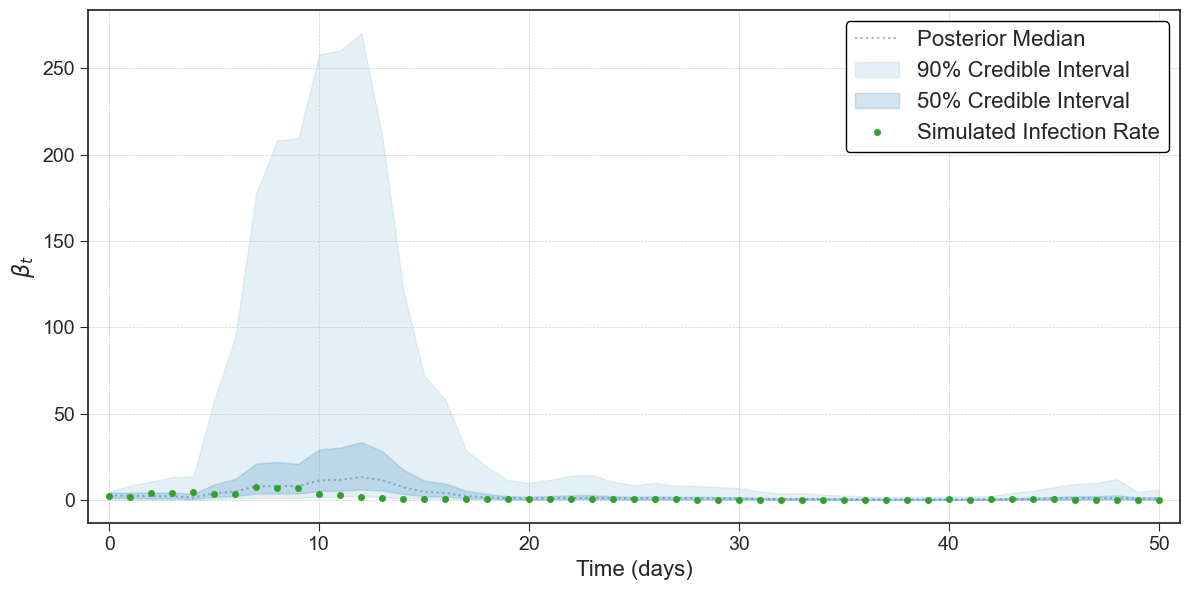

In [1419]:
beta_lineage = beta_trajectories[:,50000:]

beta_median = np.median(beta_lineage, axis=1)
# Compute the 5th and 95th percentiles for the 90% probability interval
beta_5th = np.percentile(beta_lineage, 5, axis=1)
beta_95th = np.percentile(beta_lineage, 95, axis=1)

beta_25th = np.percentile(beta_lineage, 25, axis=1)
beta_75th = np.percentile(beta_lineage, 75, axis=1)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

plt.plot(beta_median, color=colors[1], alpha=0.5, linestyle=':', label='Posterior Median')
plt.fill_between(range(beta_lineage.shape[0]), beta_5th, beta_95th, 
                 color=colors[0], alpha=0.3, label='90% Credible Interval')
plt.fill_between(range(beta_lineage.shape[0]), beta_25th, beta_75th, 
                 color=colors[1], alpha=0.2, label='50% Credible Interval')
plt.plot(np.exp(states[4,0,:]), marker='o', linewidth=0, markersize=4, color=colors[3], label='Simulated Infection Rate')
plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.xlim(-1,51)
plt.xlabel('Time (days)', fontsize=16)
plt.ylabel(r'$\beta_t$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


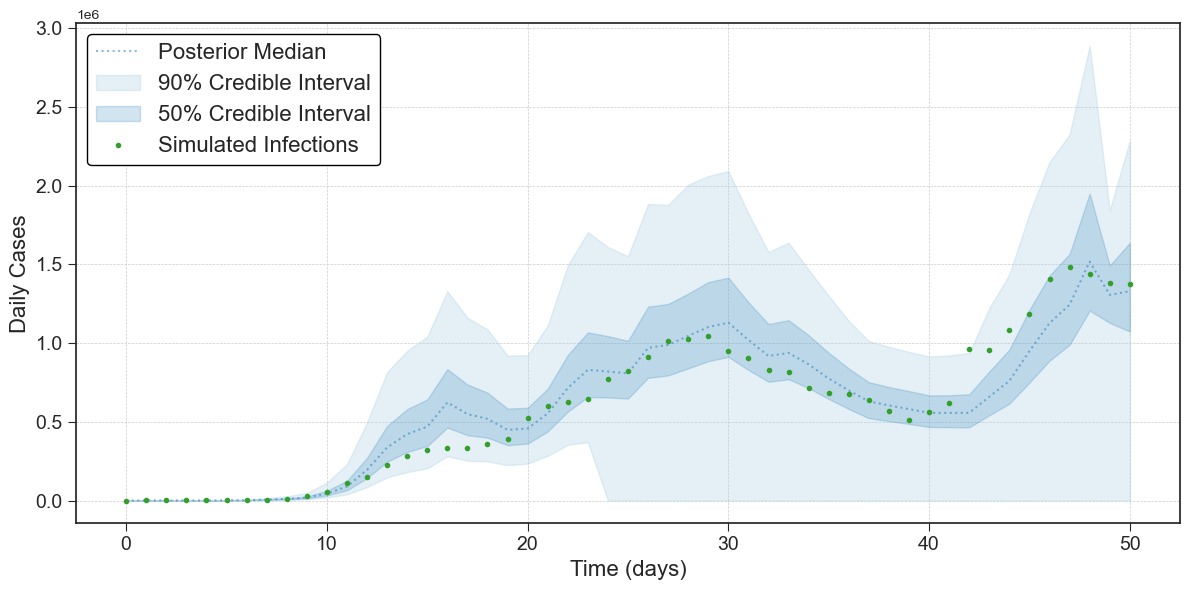

In [1418]:
infections_lineage = weekly_trajectories[:,50000:]

infections_median = np.median(infections_lineage, axis=1)
# Compute the 5th and 95th percentiles for the 90% probability interval
infections_5th = np.percentile(infections_lineage, 5, axis=1)
infections_95th = np.percentile(infections_lineage, 95, axis=1)

infections_25th = np.percentile(infections_lineage, 25, axis=1)
infections_75th = np.percentile(infections_lineage, 75, axis=1)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

plt.plot(infections_median, color=colors[1], alpha=0.5, linestyle=':', label='Posterior Median')
plt.fill_between(range(infections_lineage.shape[0]), infections_5th, infections_95th, 
                 color=colors[0], alpha=0.3, label='90% Credible Interval')
plt.fill_between(range(infections_lineage.shape[0]), infections_25th, infections_75th, 
                 color=colors[1], alpha=0.2, label='50% Credible Interval')
plt.plot(aggregates[0,:], marker='o', linewidth=0, markersize=3, color=colors[3], label='Simulated Infections')
plt.legend(
    loc='upper left',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.xlabel('Time (days)', fontsize=16)
plt.ylabel('Daily Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Sensibility Analysis for Gamma

In [1345]:
def SENS_SEIR(V_in, kappa, gamma, beta, num_particles, N):
    # Initialize arrays to store results
    V = np.zeros([V_in.shape[0], num_particles])
    
    new_infected = np.zeros([num_particles])

    # Update SEUORDS model
    V[0, :] = V_in[0, :] - beta * V_in[0, :] * V_in[2, :] / N                                 # S-Susceptibles
    V[1, :] = V_in[1, :] + beta * V_in[0, :] * V_in[2, :] / N - kappa * V_in[1, :]            # E-Exposed
    V[2, :] = V_in[2, :] + kappa * V_in[1, :] - gamma * V_in[2, :]                            # I-Infected
    V[3, :] = V_in[3, :] + gamma * V_in[2, :]                                                 # R-Recovered
    
    new_infected =  kappa*V_in[1, :]
    
    return V, new_infected

In [1388]:
T = 50
num_particles = 10000
test_beta = np.exp(states[-1,:,:])[0,:]
gammas = stats.uniform(0,1).rvs(num_particles)

tests = np.zeros([4, num_particles, T+1])  
tests[:, :, 0] = np.tile(V_in[:4,0], (num_particles,1)).T

test_aggregates = np.zeros([num_particles, T+1])
test_aggregates[:,0] = tests[2,:,0]

# Run the model over T periods with weekly aggregation
for t in range(1, T+1):
    tests[:, :, t], test_aggregates[:, t] = SENS_SEIR(tests[:, :, t-1], kappa, gammas, test_beta[0], num_particles, N)

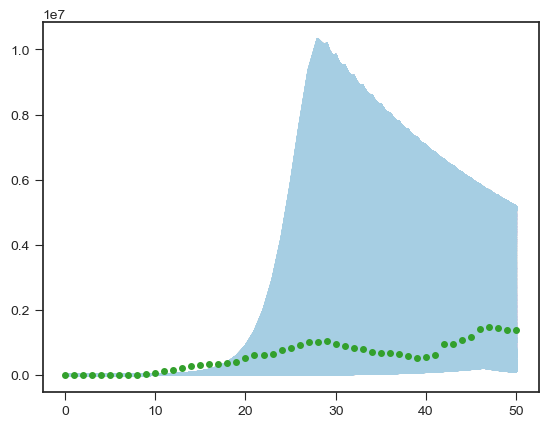

In [1404]:
for n in range(num_particles):
    plt.plot(test_aggregates[n, :], color=colors[0])
plt.plot(aggregates[0,:], marker='o', linewidth=0, markersize=4, color=colors[3])
plt.show()

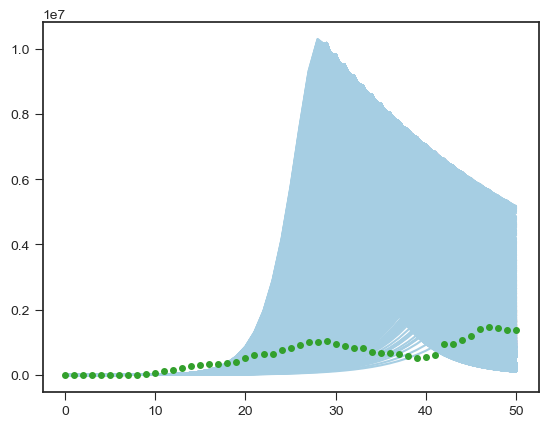

In [1405]:
T = 50
num_particles = 10000
test_beta = np.exp(states[-1,:,:])[0,:]
gammas = stats.beta(2.36, 9.44).rvs(num_particles)

tests = np.zeros([4, num_particles, T+1])  
tests[:, :, 0] = np.tile(V_in[:4,0], (num_particles,1)).T

test_aggregates = np.zeros([num_particles, T+1])
test_aggregates[:,0] = tests[2,:,0]

# Run the model over T periods with weekly aggregation
for t in range(1, T+1):
    tests[:, :, t], test_aggregates[:, t] = SENS_SEIR(tests[:, :, t-1], kappa, gammas, test_beta[0], num_particles, N)
    
for n in range(num_particles):
    plt.plot(test_aggregates[n, :], color=colors[0])
plt.plot(aggregates[0,:], marker='o', linewidth=0, markersize=4, color=colors[3])
plt.show()